In [8]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
import librosa

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")


In [9]:
# Load and preprocess audio
audio, sr = librosa.load("hindi_akshat.mp3", sr=16000)
inputs = processor(audio, sampling_rate=16000, return_tensors="pt")

# Extract token embeddings
with torch.no_grad():
    outputs = model(**inputs)
    tokens = outputs.last_hidden_state  # Shape: (batch_size, time_steps, hidden_dim)

In [10]:
#tokens = tokens.reshape(-1, tokens.shape[-1]).shape  # Reshape to (num_tokens, hidden_dim)


In [52]:
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns
import warnings
from glob import glob
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import math
from torch import Tensor
import torch
from einops import rearrange
import torch.nn.functional as F
from einops.layers.torch import Rearrange,Reduce


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(embed_dim, expansion * embed_dim),
            nn.ReLU(),
            nn.Linear(expansion*embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        attn_output, _ = self.attention(x, x, x, attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x
    
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(emb_size, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes),
            nn.Softmax(dim=2)
            
        )

    def forward(self, x):
        out = self.fc(x)
        return out
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size,num_heads=6,expansion=4) for _ in range(depth)])
class Classifier(nn.Sequential):
    def __init__(self, emb_size=40, depth=3, **kwargs):
        super().__init__(
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, 9)
        )

class TransformerWithCLS(nn.Module):
    def __init__(self, emb_size, depth=3, num_classes=9,src_key_padding_mask=None):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.transformer = TransformerEncoder(depth, emb_size)  # your custom encoder
        self.classifier = ClassificationHead(emb_size, num_classes)

    def forward(self, x, src_key_padding_mask=None):
        B = x.size(0)
        cls_tok = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls_tok, x], dim=1)  # (B, seq_len + 1, emb_size)
        x = x.transpose(0, 1)  # -> (seq_len + 1, B, emb_size)

        if src_key_padding_mask is not None:
            pad = torch.zeros((B, 1), dtype=src_key_padding_mask.dtype, device=src_key_padding_mask.device)
            src_key_padding_mask = torch.cat([pad, src_key_padding_mask], dim=1)

        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        cls_out = x[0]  # Take output of CLS token (at position 0)
        return self.classifier(cls_out)



In [36]:
from torch.utils.data import DataLoader, Dataset

langs = ["Hindi", "Kannada", "Tamil", "Telugu","Urdu","Malayalam", "Bengali", "Marathi", "Gujarati"]
mfccs_feature = []
classes = []
for lang in langs:
    file_name = f"{lang}_tokens.pkl"
    # print(f"Shape of {file_name}: {np.array(features['features']).shape}")
    try:
        with open(file_name, "rb") as f:
            if file_name == "Punjabi_features.pkl":
                features = pickle.load(f)
                mfccs_feature += features[:500]
                classes += ([lang] * len(features[:500]))
            else:
                features = pickle.load(f)
                mfccs_feature+=features["tokens"][:500]
                tot_lang=[lang]*len(features["tokens"][:500])
                classes+=tot_lang
    except FileNotFoundError:
        print(f"File {file_name} not found.")

df = pd.DataFrame({'MFCC_Features': mfccs_feature, 'Class': classes})


In [13]:
print(df.shape)

(4485, 2)


In [53]:
# Load the model weights
model1 = Classifier(emb_size=768)
model2 = TransformerWithCLS(emb_size=768, depth=3,num_classes=9)

In [54]:
tokens_tensor = torch.tensor(tokens)
print(tokens_tensor.shape)  # Print the shape of the tensor
numpy_array = model1(tokens_tensor).detach().numpy()  # Convert to numpy array
print(numpy_array.shape)  # Print the shape of the numpy array

torch.Size([1, 273, 768])
(1, 273, 9)


/tmp/ipykernel_316584/2498360444.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(tokens)


In [55]:
new_df = df.sample(4485, random_state=42)


In [56]:
def fix_shape(tensor):
    if tensor.dim() == 3 and tensor.shape[0] == 1:
        return tensor.squeeze(0)
    return tensor

In [57]:
lbl = LabelEncoder()
y = lbl.fit_transform(new_df['Class'])
#X = np.array(new_df['MFCC_Features'].tolist())
#X = np.array([i.detach().numpy() for i in new_df['MFCC_Features']])
X = new_df['MFCC_Features'].apply(fix_shape).to_numpy()

y = np.array(y.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [58]:
print(torch.tensor([y_train[9] for i in range(10)])) ## number of classes hardcoded
print(X_train[10])

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
tensor([[-0.1400, -0.1221,  0.2917,  ...,  0.2630,  0.2870, -0.3109],
        [-0.1547, -0.1405,  0.2934,  ...,  0.4145,  0.3077, -0.4269],
        [-0.1987, -0.1161,  0.2483,  ...,  0.3662,  0.2649, -0.3051],
        ...,
        [ 0.0411, -0.0408,  0.1974,  ...,  0.4705,  0.3183, -0.2484],
        [ 0.0405, -0.0412,  0.2654,  ...,  0.4416,  0.3900, -0.2943],
        [ 0.0977, -0.0576,  0.2818,  ...,  0.3450,  0.3696, -0.3721]])


In [59]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# ----------------------
# Dataset
# ----------------------
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# ----------------------
# Collate function with padding
# ----------------------
def collate_fn(batch):
    sequences, labels = zip(*batch)

    # DEBUG: Print sequence shapes before padding
    print("Raw sequence lengths:", [s.shape for s in sequences])

    padded = pad_sequence(sequences, batch_first=True)
    print("Padded batch shape:", padded.shape)  # (B, max_seq_len, feature_dim)

    lengths = torch.tensor([seq.shape[0] for seq in sequences])
    max_len = padded.size(1)
    pad_mask = torch.arange(max_len).expand(len(lengths), max_len) >= lengths.unsqueeze(1)

    print("Padding mask shape:", pad_mask.shape)  # (B, max_seq_len)

    return padded, torch.tensor(labels), pad_mask


# ----------------------
# Training function
# ----------------------
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-4, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch, pad_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch, pad_mask = X_batch.to(device), y_batch.to(device), pad_mask.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch, src_key_padding_mask=pad_mask)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Train loss = {total_loss / len(train_loader):.4f}")
        
        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch, pad_mask in test_loader:
                X_batch, y_batch, pad_mask = X_batch.to(device), y_batch.to(device), pad_mask.to(device)
                outputs = model(X_batch, src_key_padding_mask=pad_mask)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        print(f"Test Accuracy: {acc:.4f}")



In [60]:
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

train_model(model2, train_loader, test_loader, epochs=10, lr=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu')


Epoch 1/10:   0%|          | 0/113 [00:00<?, ?it/s]/tmp/ipykernel_316584/665725537.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
Epoch 1/10:   0%|          | 0/113 [00:00<?, ?it/s]

Raw sequence lengths: [torch.Size([249, 768]), torch.Size([248, 768]), torch.Size([248, 768]), torch.Size([250, 768]), torch.Size([248, 768]), torch.Size([248, 768]), torch.Size([248, 768]), torch.Size([244, 768]), torch.Size([250, 768]), torch.Size([249, 768]), torch.Size([248, 768]), torch.Size([239, 768]), torch.Size([244, 768]), torch.Size([248, 768]), torch.Size([244, 768]), torch.Size([248, 768]), torch.Size([248, 768]), torch.Size([249, 768]), torch.Size([248, 768]), torch.Size([248, 768]), torch.Size([248, 768]), torch.Size([250, 768]), torch.Size([248, 768]), torch.Size([245, 768]), torch.Size([249, 768]), torch.Size([248, 768]), torch.Size([250, 768]), torch.Size([248, 768]), torch.Size([248, 768]), torch.Size([249, 768]), torch.Size([248, 768]), torch.Size([221, 768])]
Padded batch shape: torch.Size([32, 250, 768])
Padding mask shape: torch.Size([32, 250])


TypeError: Sequential.forward() got an unexpected keyword argument 'src_key_padding_mask'

In [22]:
# Define the loss function and optimizer
# Ensure the model is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Convert data to PyTorch tensors and move to GPU
#X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
#y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Training loop
epochs = 10
batch_size = 1
model1.to(device)

from tqdm import tqdm  # Import tqdm for progress bar
for epoch in range(epochs):
    model.train()
    epoch_loss = 0


    for i in tqdm(range(0, len(X_train)), desc=f"Epoch {epoch+1}/{epochs}"):
        X_batch = X_train[i].to(device)
        y_batch = y_train[i]
        optimizer.zero_grad()
        outputs = model1(X_batch)
        outputs = outputs.squeeze(0)
        y_batch = torch.tensor([y_batch] * outputs.shape[0], dtype=torch.long).to(device)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(X_train):.4f}")
# Save the trained model
torch.save(model1.state_dict(), "classifier_model.pth")

Epoch 1/10: 100%|██████████| 3588/3588 [00:37<00:00, 95.04it/s] 


Epoch 1/10, Loss: 2.1968


Epoch 2/10: 100%|██████████| 3588/3588 [00:39<00:00, 90.89it/s] 


Epoch 2/10, Loss: 2.1969


Epoch 3/10: 100%|██████████| 3588/3588 [00:39<00:00, 89.72it/s] 


Epoch 3/10, Loss: 2.1968


Epoch 4/10: 100%|██████████| 3588/3588 [00:40<00:00, 88.58it/s]


Epoch 4/10, Loss: 2.1969


Epoch 5/10: 100%|██████████| 3588/3588 [00:41<00:00, 85.80it/s] 


Epoch 5/10, Loss: 2.1968


Epoch 6/10: 100%|██████████| 3588/3588 [00:41<00:00, 87.46it/s]


Epoch 6/10, Loss: 2.1969


Epoch 7/10: 100%|██████████| 3588/3588 [00:41<00:00, 87.46it/s]


Epoch 7/10, Loss: 2.1968


Epoch 8/10: 100%|██████████| 3588/3588 [00:36<00:00, 97.48it/s] 


Epoch 8/10, Loss: 2.1969


Epoch 9/10: 100%|██████████| 3588/3588 [00:39<00:00, 90.04it/s] 


Epoch 9/10, Loss: 2.1968


Epoch 10/10: 100%|██████████| 3588/3588 [00:41<00:00, 85.93it/s]


Epoch 10/10, Loss: 2.1968


In [20]:
model.eval()

# Get predictions
with torch.no_grad():
    y_pred = []
    for i in range(len(X_test)):
        X_batch = X_test[i].to(device)
        outputs = model1(X_batch)
        outputs = outputs.squeeze(0)
        y_pred.append(outputs.argmax().item())
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    print(y_pred.shape)
    print(y_pred)
    print(y_test.shape)
# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

(897,)
[2170  181   73 2026 1616 1027  604 1588  973  838  856 1837 2093 1504
 1459 1063 1617 1714 1909  703  937  523 1726  752  451  329 1495 1972
 2089 1279 2062 2165 2170  352 1450   10 2035  109 2173  788  622 1192
 2020 2089    1  586 1175 1598  640 1747  136 1288 1894 1117 1306  316
  284  532 1653 1351 1810 1994 1873 1234 2161 1441  140 1126 1450 1342
  829  761 1858 1462 1549 1450 1387 1175 1382 1004 1508  338  563 1048
  964  496 2138 1693 2044   19 1903   22  428 1976 1351 1045  379 1486
 1165 1162  712 1414 1522  347 1912  896  514  293 2206 1477 1828  590
   73 1333  856  163  766 2089  991  631 1216  121 1702 2089 1324 1544
 1549  496  307 1319 1903  559 1837 1162 1702  892  541 1093 1985 1972
 1759 1567 1027 1945  734   58 1706 1000  976  235  901  643 1324  163
  739 1174 1108  973 1972 2215 1351 1207  392  410 1450  118 1621  127
  688  622 1468  145  168 1918  838  667 2143 1567 1171  253  860  595
  460 1009  491   73  217 1868  523  145  433 1621 1225   64 1675 1450

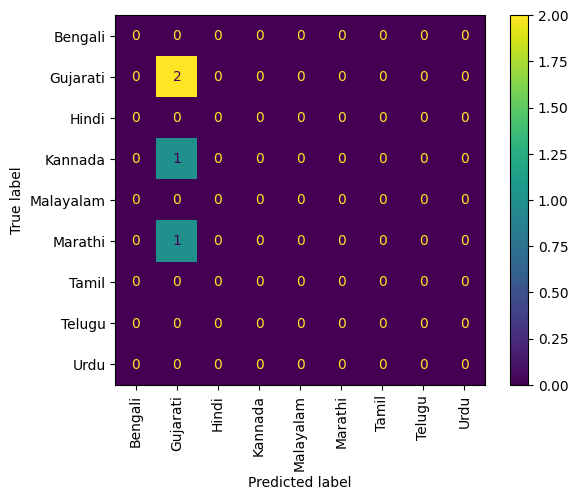

In [21]:
cnf = confusion_matrix(y_test, y_pred, labels=range(len(lbl.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf, display_labels=lbl.classes_)
disp.plot()
plt.xticks(rotation=90)
plt.show()